
<div class="alert alert-info" role="alert">
  <p>
    <center><b>Usage Guidelines</b></center>
  </p>

  <p>
    This lesson is part of the <b>DS Lab core curriculum</b>. For that reason, this notebook can only be used on your WQU virtual machine.
  </p>

  <p>
    This means:
    <ul>
      <li><span style="color: red">ⓧ</span> No downloading this notebook.</li>
      <li><span style="color: red">ⓧ</span> No re-sharing of this notebook with friends or colleagues.</li>
      <li><span style="color: red">ⓧ</span> No downloading the embedded videos in this notebook.</li>
      <li><span style="color: red">ⓧ</span> No re-sharing embedded videos with friends or colleagues.</li>
      <li><span style="color: red">ⓧ</span> No adding this notebook to public or private repositories.</li>
      <li><span style="color: red">ⓧ</span> No uploading this notebook (or screenshots of it) to other websites, including websites for study resources.</li>
    </ul>

  </p>
</div>


<font size="+3"><strong>2.4. Predicting Price with Size, Location, and Neighborhood</strong></font>

In [6]:
import warnings
from glob import glob

import pandas as pd
import seaborn as sns
import wqet_grader
from category_encoders import OneHotEncoder
from IPython.display import VimeoVideo
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)
wqet_grader.init("Project 2 Assessment")

In the final lesson for this project, we're going to try to use all the features in our dataset to improve our model. This means that we'll have to do a more careful cleaning of the dataset and consider some of the finer points of linear models.

In [2]:
VimeoVideo("656842813", h="07f074324e", width=600)

# Prepare Data

## Import

In [3]:
def wrangle(filepath) -> pd.DataFrame:
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # Get place name
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace=True)
    
    # Drop features with high null counts
    df.drop(columns=["floor", "expenses"], inplace=True)
    
    # Drop low- and high-cardinality cols
    df.drop(columns=["operation", "property_type",	"currency",	"properati_url"], inplace=True)
    
    # Drop leaky columns
    df.drop(columns=[ 'price', 'price_aprox_local_currency', 'price_per_m2', 'price_usd_per_m2'], inplace=True)
    
    # Drop columns with mulcollinearity 
    df.drop(columns=["surface_total_in_m2", "rooms"], inplace=True)
    return df

Let's begin by using what we've learned to load all our CSV files into a DataFrame. 

In [3]:
VimeoVideo("656842538", h="bd85634eb1", width=600)

**Task 2.4.1:** Use [`glob`](https://docs.python.org/3/library/glob.html#glob.glob) to create a list that contains the filenames for all the Buenos Aires real estate CSV files in the `data` directory. Assign this list to the variable name `files`.

- [<span id='technique'>Assemble a list of path names that match a pattern in <span id='tool'>glob.](../%40textbook/02-python-advanced.ipynb#Working-with-strings-)

In [4]:
files = glob("data/buenos-aires-real-estate-*.csv")
files

['data/buenos-aires-real-estate-5.csv',
 'data/buenos-aires-real-estate-4.csv',
 'data/buenos-aires-real-estate-3.csv',
 'data/buenos-aires-real-estate-1.csv',
 'data/buenos-aires-real-estate-2.csv']

In [4]:
# Check your work
assert len(files) == 5, f"`files` should contain 5 items, not {len(files)}"

The last time we put all our DataFrames into a list, we used a `for` loop. This time, we're going to use a more compact coding technique called a **list comprehension**.  

In [6]:
VimeoVideo("656842076", h="0f654d427f", width=600)

**Task 2.4.2:** Use your `wrangle` function in a list comprehension to create a list named `frames`. The list should contain the cleaned DataFrames for the filenames your collected in `files`.

- [What's a list comprehension?](../%40textbook/02-python-advanced.ipynb#List-Comprehension-)
- [Write a list comprehension in Python](../%40textbook/02-python-advanced.ipynb#List-Comprehension-)

In [7]:
from typing import List
frames: List[pd.DataFrame] = [wrangle(file) for file in files]
frames[0]

,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
3,112000.0,60.0,-34.564676,-58.455720,Belgrano
9,76500.0,36.0,-34.618830,-58.437779,Caballito
18,90000.0,100.0,-34.577168,-58.538654,Belgrano
20,159900.0,77.0,-34.571526,-58.455637,Colegiales
21,123875.0,50.0,-34.578688,-58.457358,Colegiales
...,...,...,...,...,...
8566,290000.0,83.0,-34.639528,-58.519666,Liniers
8573,150000.0,45.0,-34.597825,-58.416439,Palermo
8577,65000.0,42.0,-34.652233,-58.490739,Mataderos
8578,91440.0,48.0,-34.648761,-58.500180,Mataderos


In [8]:
# Check your work
assert len(frames) == 5, f"`frames` should contain 5 items, not {len(frames)}"
assert all(
    [isinstance(frame, pd.DataFrame) for frame in frames]
), "The items in `frames` should all be DataFrames."

Last step: Combine the DataFrames in `frames` into a single `df`.

In [7]:
VimeoVideo("656841910", h="79c7dbc5ab", width=600)

**Task 2.4.3:** Use [`pd.concat`](https://pandas.pydata.org/docs/reference/api/pandas.concat.html) to concatenate it items in `frames` into a single DataFrame `df`. Make sure you set the `ignore_index` argument to `True`.

- [<span id='technique'>Concatenate two or more DataFrames using <span id='tool'>pandas.](../%40textbook/03-pandas-getting-started.ipynb#Concatenating)

In [9]:
df = pd.concat(
    frames := [wrangle(file) for file in files], 
    ignore_index=True
)

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        6582 non-null   float64
 1   surface_covered_in_m2  6582 non-null   float64
 2   lat                    6316 non-null   float64
 3   lon                    6316 non-null   float64
 4   neighborhood           6582 non-null   object 
dtypes: float64(4), object(1)
memory usage: 257.2+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
0,112000.0,60.0,-34.564676,-58.455720,Belgrano
1,76500.0,36.0,-34.618830,-58.437779,Caballito
2,90000.0,100.0,-34.577168,-58.538654,Belgrano
3,159900.0,77.0,-34.571526,-58.455637,Colegiales
4,123875.0,50.0,-34.578688,-58.457358,Colegiales


In [8]:
# Check your work
assert len(df) == 6582, f"`df` has the wrong number of rows: {len(df)}"
assert df.shape[1] <= 17, f"`df` has too many columns: {df.shape[1]}"

In [5]:
%who

Dropdown	 FloatSlider	 IntSlider	 LinearRegression	 OneHotEncoder	 Ridge	 SimpleImputer	 VimeoVideo	 check_is_fitted	 
df	 files	 frames	 glob	 interact	 make_pipeline	 mean_absolute_error	 pd	 sns	 
warnings	 wqet_grader	 wrangle	 


## Explore

The first thing we need to consider when trying to use all the features `df` is **missing values**. While it's true you can impute missing values, there still needs to be enough data in a column to do a good imputation. A general rule is that, if more than half of the data in a column is missing, it's better to drop it then try imputing.

Take a look at the output from `df.info()` above. Are there columns where more than half of the values are `NaN`? If so, those columns need to go! 

In [12]:
VimeoVideo("656848648", h="6964fa0c8c", width=600)

**Task 2.4.4:** Modify your `wrangle` function to drop any columns that are more than half `NaN` values. Be sure to rerun all the cells above before you continue.

- [<span id='technique'>Inspect a DataFrame using the `shape`, `info`, and `head` in <span id='tool'>pandas.](../%40textbook/03-pandas-getting-started.ipynb#Inspecting-DataFrames)
- [<span id='technique'>Drop a column from a DataFrame using <span id='tool'>pandas.](../%40textbook/03-pandas-getting-started.ipynb#Dropping-Columns)

In [10]:
df.isnull().sum() / len(df)

price_aprox_usd          0.000000
surface_covered_in_m2    0.000000
lat                      0.040413
lon                      0.040413
neighborhood             0.000000
dtype: float64

In [21]:
# Check your work
assert len(df) == 6582, f"`df` has the wrong number of rows: {len(df)}"
assert df.shape[1] <= 15, f"`df` has too many columns: {df.shape[1]}"

The next thing we need to look out for are categorical columns with **low or high cardinality**. If there's only one category in a column, it won't provide any unique information to our model. At the other extreme, columns where nearly every row has its own category won't help our model in identifying useful trends in the data.

Let's take a look at the cardinality of our features.

In [22]:
VimeoVideo("656848196", h="37dbc44b09", width=600)

**Task 2.4.5:** Calculate the number of unique values for each non-numeric feature in `df`.

- [<span id='technique'>Subset a DataFrame's columns based on the column data types in <span id='tool'>pandas.](../%40textbook/04-pandas-advanced.ipynb#Subset-the-Columns-of-a-DataFrame-Based-on-Data-Types)
- [<span id='technique'>Calculate summary statistics for a DataFrame or Series in <span id='tool'>pandas.](../%40textbook/05-pandas-summary-statistics.ipynb#Working-with-Summary-Statistics)

In [23]:
df.select_dtypes("object").head()

,operation,property_type,currency,properati_url,neighborhood
0,sell,apartment,USD,http://belgrano.properati.com.ar/116pr_venta_d...,Belgrano
1,sell,apartment,USD,http://caballito.properati.com.ar/12ksf_venta_...,Caballito
2,sell,apartment,USD,http://belgrano.properati.com.ar/zouu_venta_de...,Belgrano
3,sell,apartment,USD,http://colegiales.properati.com.ar/zpcd_venta_...,Colegiales
4,sell,apartment,USD,http://colegiales.properati.com.ar/12sbf_venta...,Colegiales


In [26]:
df.select_dtypes("object").nunique()

operation           1
property_type       1
currency            2
properati_url    6582
neighborhood       57
dtype: int64

Here, we can see that columns like `"operation"` have only one value in them, while every row in `"properati_url"` has a unique value. These are clear examples of high- and low-cardinality features that we shouldn't include in our model.

**Task 2.4.6:** Modify your `wrangle` function to drop high- and low-cardinality categorical features.

Be sure to rerun all the cells above before you continue.

- [What are <span id='term'>high- and low-cardinality features?](../%40textbook/14-ml-classification.ipynb#High-cardinality-Features)
- [<span id='technique'>Drop a column from a DataFrame using <span id='tool'>pandas.](../%40textbook/03-pandas-getting-started.ipynb#Dropping-Columns)

In [13]:
# Check your work
assert len(df) == 6582, f"`df` has the wrong number of rows: {len(df)}"
assert df.shape[1] <= 11, f"`df` has too many columns: {df.shape[1]}"

It's also important for us to drop any columns that would constitute **leakage**, that is, features that were created using our target or that would give our model information that it won't have access to when it's deployed. 

In [14]:
VimeoVideo("656847896", h="11de775937", width=600)

**Task 2.4.7:** Modify your `wrangle` function to drop any features that would constitute leakage. 

Be sure to rerun all the cells above before you continue.

- [What's <span id='term'>leakage?](../%40textbook/12-ml-core.ipynb#Leakage)
- [<span id='technique'>Drop a column from a DataFrame using <span id='tool'>pandas.](../%40textbook/03-pandas-getting-started.ipynb#Dropping-Columns)

In [15]:
sorted(df.columns)

['lat',
 'lon',
 'neighborhood',
 'price',
 'price_aprox_local_currency',
 'price_aprox_usd',
 'price_per_m2',
 'price_usd_per_m2',
 'rooms',
 'surface_covered_in_m2',
 'surface_total_in_m2']

In [18]:
# Check your work
assert len(df) == 6582, f"`df` has the wrong number of rows: {len(df)}"
assert df.shape[1] <= 7, f"`df` has too many columns: {df.shape[1]}"

Finally, the last issue we need to keep an eye out for is **multicollinearity**, that is, features in our feature matrix that are highly correlated with each other. A good way to detect this is to use a heatmap. Let's make one!

In [19]:
VimeoVideo("656847237", h="4b5cfed5d6", width=600)

**Task 2.4.8:** Plot a correlation heatmap of the remaining numerical features in `df`. Since `"price_aprox_usd"` will be your target, you don't need to include it in your heatmap.

- [What's a <span id='term'>heatmap?](../%40textbook/09-visualization-seaborn.ipynb#Correlation-Heatmaps)
- [<span id='technique'>Create a correlation matrix in <span id='tool'>pandas.](../%40textbook/07-visualization-pandas.ipynb#Correlation-Matrices)
- [<span id='technique'>Create a heatmap in <span id='tool'>seaborn.](../%40textbook/09-visualization-seaborn.ipynb#Correlation-Heatmaps)

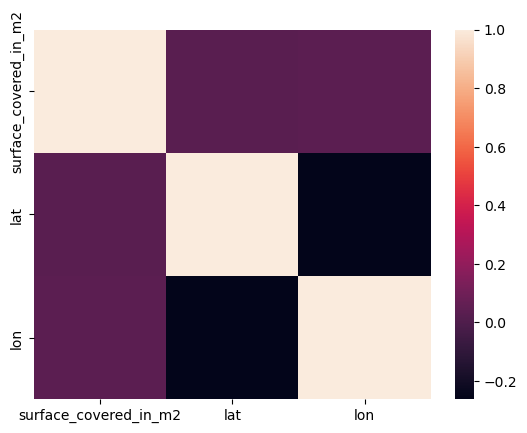

In [6]:
corr = df.select_dtypes("number").drop(columns="price_aprox_usd").corr()
sns.heatmap(corr);

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        6582 non-null   float64
 1   surface_covered_in_m2  6582 non-null   float64
 2   lat                    6316 non-null   float64
 3   lon                    6316 non-null   float64
 4   neighborhood           6582 non-null   object 
dtypes: float64(4), object(1)
memory usage: 257.2+ KB


**Task 2.4.9:** Modify your `wrangle` function to remove columns so that there are no strongly correlated features in your feature matrix.

Be sure to rerun all the cells above before you continue.

- [What's <span id='term'>multicollinearity?](../%40textbook/15-ml-regression.ipynb#Multicollinearity)
- [<span id='technique'>Drop a column from a DataFrame using <span id='tool'>pandas.](../%40textbook/03-pandas-getting-started.ipynb#Dropping-Columns)

In [28]:
# Check your work
assert len(df) == 6582, f"`df` has the wrong number of rows: {len(df)}"
assert df.shape[1] == 5, f"`df` has the wrong number of columns: {df.shape[1]}"
df.head()

,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
0,112000.0,60.0,-34.564676,-58.455720,Belgrano
1,76500.0,36.0,-34.618830,-58.437779,Caballito
2,90000.0,100.0,-34.577168,-58.538654,Belgrano
3,159900.0,77.0,-34.571526,-58.455637,Colegiales
4,123875.0,50.0,-34.578688,-58.457358,Colegiales


Done! It looks like we're going to use the four features we've used in our previous models but, this time, we're going to combine them. 

## Split Data

**Task 2.4.10:** Create your feature matrix `X_train` and target vector `y_train`. Your target is `"price_aprox_usd"`. Your features should be all the columns that remain in the DataFrame you cleaned above.

- [What's a <span id='term'>feature matrix?](../%40textbook/15-ml-regression.ipynb#Linear-Regression)
- [What's a <span id='term'>target vector?](../%40textbook/15-ml-regression.ipynb#Linear-Regression)
- [<span id='technique'>Subset a DataFrame by selecting one or more columns in <span id='tool'>pandas.](../%40textbook/04-pandas-advanced.ipynb#Subset-a-DataFrame-by-Selecting-One-or-More-Columns) 
- [<span id='technique'>Select a Series from a DataFrame in <span id='tool'>pandas.](../%40textbook/04-pandas-advanced.ipynb#Select-a-Series-from-a-DataFrame) 

In [7]:
target = "price_aprox_usd"
features = ["surface_covered_in_m2", "lat", "lon", "neighborhood"]
X_train = df[features]
y_train = df[target]

In [8]:
# Check your work
assert X_train.shape == (6582, 4), f"`X_train` is the wrong size: {X_train.shape}."
assert y_train.shape == (6582,), f"`y_train` is the wrong size: {y_train.shape}."

# Build Model

## Baseline

In [9]:
VimeoVideo("656849559", h="bca444c8af", width=600)

**Task 2.4.11:** Calculate the baseline mean absolute error for your model.

- [<span id='technique'>Calculate summary statistics for a DataFrame or Series in <span id='tool'>pandas.](../%40textbook/05-pandas-summary-statistics.ipynb#Working-with-Summary-Statistics)

In [11]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
print("Mean apt price:", round(y_mean, 2))

print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))

Mean apt price: 132383.84
Baseline MAE: 44860.10834274133


## Iterate

**Task 2.4.12:** Create a pipeline named `model` that contains a `OneHotEncoder`, `SimpleImputer`, and `Ridge` predictor.

- [What's <span id='term'>imputation?](../%40textbook/12-ml-core.ipynb#Imputation) 
- [What's <span id='term'>one-hot encoding?](../%40textbook/13-ml-data-pre-processing-and-production.ipynb#One-Hot-Encoding)
- [What's a <span id='term'>pipeline?](../%40textbook/13-ml-data-pre-processing-and-production.ipynb#scikit-learn-in-Production)
- [<span id='technique'>Create a pipeline in <span id='tool'>scikit-learn.](../%40textbook/13-ml-data-pre-processing-and-production.ipynb#Creating-a-Pipeline-in-scikit-learn)

In [12]:
model = make_pipeline(
    # Intantiate
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    Ridge()
)
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [13]:
# Check your work
check_is_fitted(model[-1])

## Evaluate

In [14]:
VimeoVideo("656849505", h="f153a4f005", width=600)

**Task 2.4.13:** Calculate the training mean absolute error for your predictions as compared to the true targets in `y_train`.

- [<span id='technique'>Generate predictions using a trained model in <span id='tool'>scikit-learn.](../%40textbook/15-ml-regression.ipynb#Generating-Predictions-Using-a-Trained-Model)
- [<span id='technique'>Calculate the mean absolute error for a list of predictions in <span id='tool'>scikit-learn.](../%40textbook/15-ml-regression.ipynb#Calculating-the-Mean-Absolute-Error-for-a-List-of-Predictions)

In [15]:
y_pred_training = model.predict(X_train)
print("Training MAE:", mean_absolute_error(y_train, y_pred_training))

Training MAE: 24207.10719033027


**Task 2.4.14:** Run the code below to import your test data `buenos-aires-test-features.csv` into a DataFrame and generate a list of predictions using your model. Then run the following cell to submit your predictions to the grader.

- [What's generalizability?](../%40textbook/12-ml-core.ipynb#Generalization)
- [<span id='technique'>Generate predictions using a trained model in <span id='tool'>scikit-learn.](../%40textbook/15-ml-regression.ipynb#Generating-Predictions-Using-a-Trained-Model)
- [<span id='technique'>Calculate the mean absolute error for a list of predictions in <span id='tool'>scikit-learn.](../%40textbook/15-ml-regression.ipynb#Calculating-the-Mean-Absolute-Error-for-a-List-of-Predictions)

In [16]:
X_test = pd.read_csv("data/buenos-aires-test-features.csv")
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    231122.403569
1    162572.942392
2     68477.949626
3     63521.438989
4    105694.463885
dtype: float64

In [17]:
wqet_grader.grade("Project 2 Assessment", "Task 2.4.14", y_pred_test)

# Communicate Results

For this lesson, we've relied on equations and visualizations for communication about our model. In many data science projects, however, communication means giving stakeholders tools they can use to **deploy** a model — in other words, use it in action. So let's look at two ways you might deploy this model. 

One thing you might be asked to do it wrap your model in a function so that a programmer can provide inputs and then receive a prediction as output. 

In [18]:
VimeoVideo("656849254", h="e6faad47ca", width=600)

**Task 2.4.15:** Create a function `make_prediction` that takes four arguments (`area`, `lat`, `lon`, and `neighborhood`) and returns your model's prediction for an apartment price. 

In [23]:
def make_prediction(area, lat, lon, neighborhood):
    data = {
        "surface_covered_in_m2": area,
        "lat": lat,
        "lon": lon,
        "neighborhood": neighborhood
    }
    df = pd.DataFrame(data, index=[0])
    prediction = model.predict(df)
    return f"Predicted apartment price: ${prediction}"

Let's see if your function works. Run the cell below to find out!

In [24]:
make_prediction(110, -34.60, -58.46, "Villa Crespo")

'Predicted apartment price: $[250775.11270377]'

Another type of deployment is creating and interactive dashboard, where a user can supply values and receive a prediction. Let's create one using [Jupyter Widgets](https://ipywidgets.readthedocs.io/en/latest/index.html).<span style='color: transparent; font-size:1%'>WQU WorldQuant University Applied Data Science Lab QQQQ</span>

In [25]:
VimeoVideo("656848911", h="7939dcd479", width=600)

**Task 2.4.16:** Add your `make_prediction` to the interact widget below, run the cell, and then adjust the widget to see how predicted apartment price changes. 

- Create an interact function in Jupyter Widgets.

In [27]:
interact(
    make_prediction,
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    neighborhood=Dropdown(options=sorted(X_train["neighborhood"].unique())),
);

interactive(children=(IntSlider(value=53, description='area', max=101, min=30), FloatSlider(value=-34.59890626…

Great work! You may have noticed that there a lots of ways to improve this dashboard. For instance, a user can select a neighborhood and then supply latitude-longitude coordinates that aren't in that neighborhood. It would also be helpful to include a visualization like a map. Regardless, this is a great first step towards creating dynamic dashboards that turn your model from a complicated abstraction to a concrete tool that anyone can access. One of the most important parts of data science projects is creating products that people can use to make their work or lives easier. 

---
Copyright 2023 WorldQuant University. This
content is licensed solely for personal use. Redistribution or
publication of this material is strictly prohibited.
